In [2]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(os.listdir())

cuda
['sectionA_q2.ipynb', 'sectiona_q2.py']


In [39]:
NUM_EPOCHS = 100
LEARNING_RATE = 1e-3
BATCH_SIZE = 64

In [3]:
def show_image(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    grid = torchvision.utils.make_grid(images, nrow=3)
    grid = (grid - grid.min()) / (grid.max() - grid.min())
    plt.figure(figsize=(11, 11))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis("off")
    plt.show()
    print(labels)

In [40]:
from tqdm import tqdm
os.makedirs("./models", exist_ok=True)
def train_model(model, train_loader, val_loader, optimizer=None, criterion=None, verbose=True):
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
    # assuming model already in cuda device
    n_total_steps = len(train_loader)
    epochs = []
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    for epoch in tqdm(range(NUM_EPOCHS)):
        train_loss = 0.
        val_loss = 0.
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            batch_size = labels.size(0)
            outputs = model(images)
            loss = criterion(outputs, labels) # averaged over the batch
            train_loss += loss.item() * batch_size
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if verbose and (i + 1) % 50 == 0:
                print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}")
        train_loss /= len(train_loader.dataset)
        epochs.append(epoch + 1)
        train_losses.append(train_loss)
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                batch_size = labels.size(0)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * batch_size
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        if verbose:
            print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Train loss {train_loss:.4f}, Val loss {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict()
            }, f"./models/Epoch{epoch+1}.pth")
            if verbose:
                print("Saved best model")

    if verbose:
        print("Finished training")
    plt.plot(epochs, train_losses, label="Train Loss", marker="o")
    plt.plot(epochs, val_losses, label="Val Loss", marker="o")
    plt.legend()
    plt.show()

In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
def evaluate_model(model, test_loader, class_names, criterion=None):
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    cm = confusion_matrix(all_labels, all_preds)
    print('\033[1m' + 'Printing statistics...' + '\033[0m')
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Overall Accuracy: {acc:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    class_acc = cm.diagonal() / cm.sum(axis=1)
    for i, class_name in enumerate(class_names):
        print(f"Accuracy for class {class_name}: {class_acc[i]:.4f}")
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    return test_loss, acc, f1, cm, class_acc

## Task 1

In [6]:
# CIFAR10 dataset
# Image preprocessing modules
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize
])
transform_val = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    normalize
])

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fedesoriano/cifar10-python-in-csv")

print("Path to dataset files:", path)

C:\Users\shubh\micromamba\envs\pytorch-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 209M/209M [00:37<00:00, 5.85MB/s] 

Extracting files...


Path to dataset files: C:\Users\shubh\.cache\kagglehub\datasets\fedesoriano\cifar10-python-in-csv\versions\1


In [13]:
os.listdir("../../../../.cache/kagglehub/datasets/fedesoriano/cifar10-python-in-csv/versions/1")

['batches.meta', 'test.csv', 'train.csv']

In [14]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [15]:
metadata_path = '../../../../.cache/kagglehub/datasets/fedesoriano/cifar10-python-in-csv/versions/1/batches.meta'
metadata = unpickle(metadata_path)

In [16]:
print(metadata)

{b'num_cases_per_batch': 10000, b'label_names': [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck'], b'num_vis': 3072}


In [17]:
train_data_csv = pd.read_csv('../../../../.cache/kagglehub/datasets/fedesoriano/cifar10-python-in-csv/versions/1/train.csv')
test_data_csv = pd.read_csv('../../../../.cache/kagglehub/datasets/fedesoriano/cifar10-python-in-csv/versions/1/test.csv')

In [18]:
train_data = []
test_data = []

In [19]:
for i in tqdm(range(train_data_csv.shape[0])):
    row_data = np.array(train_data_csv.iloc[i], dtype = np.float64)
    pixel_data = row_data[:3072]/255
    label = int(row_data[-1])
    image = torch.zeros(3, 32, 32)
    image[0] = torch.tensor(pixel_data[:1024].reshape((32, 32)))
    image[1] = torch.tensor(pixel_data[1024:2048].reshape((32, 32)))
    image[2] = torch.tensor(pixel_data[2048:].reshape((32, 32)))
    image = torchvision.transforms.ToPILImage()(image)
    train_data.append((image, label))

for i in tqdm(range(test_data_csv.shape[0])):
    row_data = np.array(train_data_csv.iloc[i], dtype = np.float64)
    pixel_data = row_data[:3072]/255
    label = int(row_data[-1])
    image = torch.zeros(3, 32, 32)
    image[0] = torch.tensor(pixel_data[:1024].reshape((32, 32)))
    image[1] = torch.tensor(pixel_data[1024:2048].reshape((32, 32)))
    image[2] = torch.tensor(pixel_data[2048:].reshape((32, 32)))
    image = torchvision.transforms.ToPILImage()(image)
    test_data.append((image, label))

100%|██████████| 10000/10000 [00:01<00:00, 5741.22it/s]


In [20]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.transform = transform
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        img = self.data[index][0]
        if self.transform:
            img = self.transform(img)
        label = self.data[index][1]
        return img, label

In [21]:
train_dataset = MyDataset(data=train_data, transform=transform_train)
val_test_dataset = MyDataset(data=test_data, transform=transform_val)

In [22]:
size_before_split = len(val_test_dataset)
val_size = int(0.5 * size_before_split)
test_size = size_before_split - val_size
val_dataset, test_dataset = torch.utils.data.random_split(val_test_dataset, [val_size, test_size])

Displaying sample images from CIFAR-10 training set:


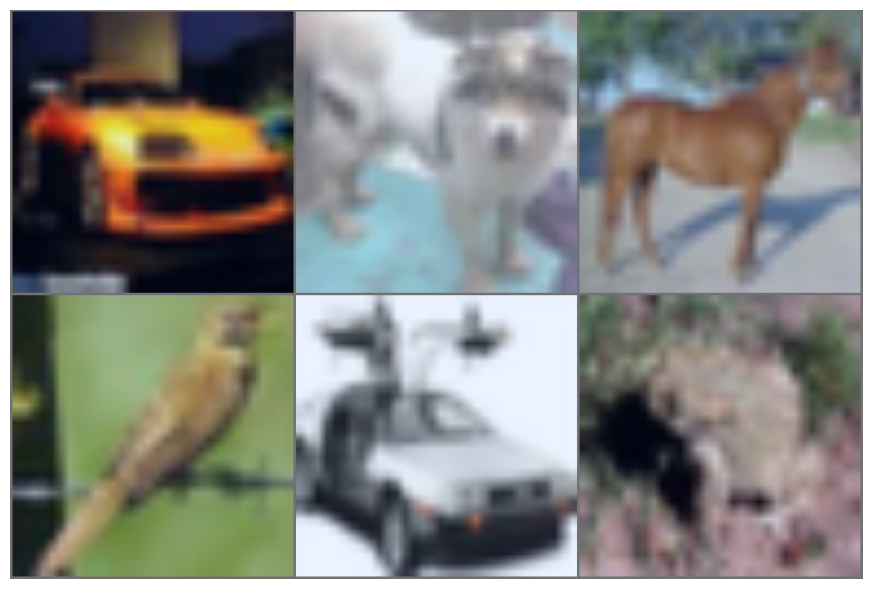

tensor([1, 5, 7, 2, 1, 6])


In [26]:
print('Displaying sample images from CIFAR-10 training set:')
show_image(train_dataset)

In [23]:
# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Task 2

In [30]:
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
print('\033[1m' + 'Model Architecture' + '\033[0m')
for name, child in model.named_children():
    print(name)

Model Architecture
conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


## Task 3

In [33]:
for param in model.parameters():
    param.requires_grad = False
num_ftrs_finetune = model.fc.in_features
num_classes = 10
model.fc = nn.Linear(num_ftrs_finetune, num_classes)
for param in model.fc.parameters():
    param.requires_grad = True

## Task 4

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/2], Step [50/782], Loss: 1.3904
Epoch [1/2], Step [100/782], Loss: 0.9814
Epoch [1/2], Step [150/782], Loss: 0.8278
Epoch [1/2], Step [200/782], Loss: 0.8939
Epoch [1/2], Step [250/782], Loss: 0.7571
Epoch [1/2], Step [300/782], Loss: 0.6937
Epoch [1/2], Step [350/782], Loss: 0.7447
Epoch [1/2], Step [400/782], Loss: 0.8463
Epoch [1/2], Step [450/782], Loss: 0.6105
Epoch [1/2], Step [500/782], Loss: 0.4917
Epoch [1/2], Step [550/782], Loss: 0.6223
Epoch [1/2], Step [600/782], Loss: 0.6069
Epoch [1/2], Step [650/782], Loss: 0.8827
Epoch [1/2], Step [700/782], Loss: 0.5749
Epoch [1/2], Step [750/782], Loss: 0.5366


 50%|█████     | 1/2 [02:30<02:30, 150.90s/it]

Epoch [1/2], Train loss 0.8279, Val loss 0.6160
Saved best model
Epoch [2/2], Step [50/782], Loss: 0.6411
Epoch [2/2], Step [100/782], Loss: 0.6567
Epoch [2/2], Step [150/782], Loss: 0.6941
Epoch [2/2], Step [200/782], Loss: 0.6397
Epoch [2/2], Step [250/782], Loss: 0.6151
Epoch [2/2], Step [300/782], Loss: 0.7786
Epoch [2/2], Step [350/782], Loss: 0.6529
Epoch [2/2], Step [400/782], Loss: 0.9199
Epoch [2/2], Step [450/782], Loss: 0.6937
Epoch [2/2], Step [500/782], Loss: 0.7075
Epoch [2/2], Step [550/782], Loss: 0.8302
Epoch [2/2], Step [600/782], Loss: 0.5970
Epoch [2/2], Step [650/782], Loss: 0.7329
Epoch [2/2], Step [700/782], Loss: 0.4807
Epoch [2/2], Step [750/782], Loss: 0.6147


100%|██████████| 2/2 [05:21<00:00, 160.84s/it]

Epoch [2/2], Train loss 0.6146, Val loss 0.5718
Saved best model
Finished training


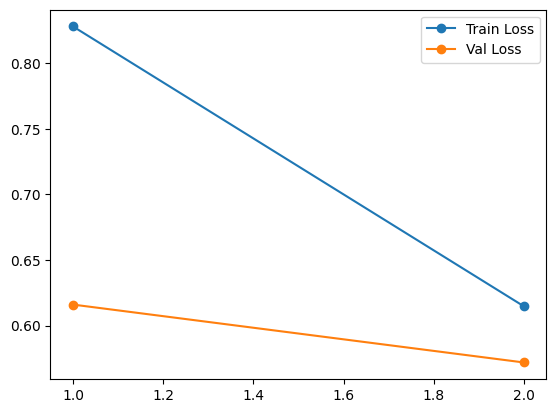

In [34]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
train_model(model, train_loader, val_loader, optimizer, criterion)

Printing statistics...
Test Loss: 0.5603
Overall Accuracy: 0.8044
F1 Score (weighted): 0.8026
Accuracy for class 0: 0.8314
Accuracy for class 1: 0.8852
Accuracy for class 2: 0.7285
Accuracy for class 3: 0.5571
Accuracy for class 4: 0.7713
Accuracy for class 5: 0.8550
Accuracy for class 6: 0.8978
Accuracy for class 7: 0.7671
Accuracy for class 8: 0.8985
Accuracy for class 9: 0.8602


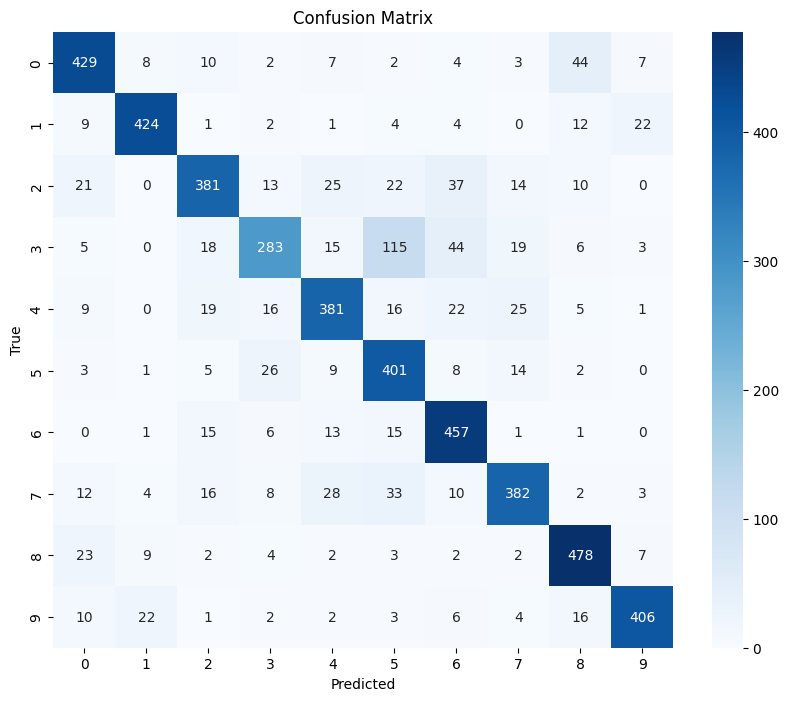

(0.5602737724304199,
 0.8044,
 0.8026165369637959,
 array([[429,   8,  10,   2,   7,   2,   4,   3,  44,   7],
        [  9, 424,   1,   2,   1,   4,   4,   0,  12,  22],
        [ 21,   0, 381,  13,  25,  22,  37,  14,  10,   0],
        [  5,   0,  18, 283,  15, 115,  44,  19,   6,   3],
        [  9,   0,  19,  16, 381,  16,  22,  25,   5,   1],
        [  3,   1,   5,  26,   9, 401,   8,  14,   2,   0],
        [  0,   1,  15,   6,  13,  15, 457,   1,   1,   0],
        [ 12,   4,  16,   8,  28,  33,  10, 382,   2,   3],
        [ 23,   9,   2,   4,   2,   3,   2,   2, 478,   7],
        [ 10,  22,   1,   2,   2,   3,   6,   4,  16, 406]]),
 array([0.83139535, 0.88517745, 0.72848948, 0.55708661, 0.77125506,
        0.85501066, 0.8978389 , 0.76706827, 0.89849624, 0.86016949]))

In [35]:
evaluate_model(model, test_loader, range(10))

## Task 5

In [26]:
def get_resnet18_custom(num_classes):
    model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
    backbone = nn.Sequential(*(list(model.children())[:-1]))
    custom_head = nn.Sequential(
        nn.Flatten()
    )
    return nn.Sequential(backbone, custom_head)
new_model = get_resnet18_custom(10).to(device)
dummy_input = torch.randn(1, 3, 224, 224).to(device)
output = new_model(dummy_input)
print(f"Output shape: {output.shape}")

Output shape: torch.Size([1, 512])


we can use this new_model to get the learned representations

In [27]:
from torch.utils.data import TensorDataset

train_features = []
val_features = []
test_features = []

train_labels = []
val_labels = []
test_labels = []

new_model.eval()

with torch.no_grad():
    # ---- Train ----
    for img, label in train_loader:
        img = img.to(device)
        output = new_model(img).detach().cpu()

        train_features.append(output)
        train_labels.append(label.cpu())
    # ---- Validation ----
    for img, label in val_loader:
        img = img.to(device)
        output = new_model(img).detach().cpu()

        val_features.append(output)
        val_labels.append(label.cpu())
    # ---- Test ----
    for img, label in test_loader:
        img = img.to(device)
        output = new_model(img).detach().cpu()

        test_features.append(output)
        test_labels.append(label.cpu())

train_features = torch.cat(train_features, dim=0)
val_features = torch.cat(val_features, dim=0)
test_features = torch.cat(test_features, dim=0)

train_labels = torch.cat(train_labels, dim=0)
val_labels = torch.cat(val_labels, dim=0)
test_labels = torch.cat(test_labels, dim=0)

train_new_dataset = TensorDataset(train_features, train_labels)
val_new_dataset = TensorDataset(val_features, val_labels)
test_new_dataset = TensorDataset(test_features, test_labels)

In [28]:
print(len(train_new_dataset))

50000


In [29]:
sample_data, sample_label = train_new_dataset[0]
print(sample_data.shape)

torch.Size([512])


In [30]:
train_new_loader = torch.utils.data.DataLoader(dataset=train_new_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_new_loader = torch.utils.data.DataLoader(dataset=val_new_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_new_loader = torch.utils.data.DataLoader(dataset=test_new_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [43]:
class ClassifierNN(nn.Module):
    def __init__(self, input_size, hidden_layers, activations, num_classes):
        super(ClassifierNN, self).__init__()
        layers = []
        in_features = input_size
        for i, (out_features, activation) in enumerate(zip(hidden_layers, activations)):
            layers.append(nn.Linear(in_features, out_features))
            if activation == 'ReLU':
                layers.append(nn.ReLU())
            elif activation == 'Tanh':
                layers.append(nn.Tanh())
            elif activation == 'LeakyReLU':
                layers.append(nn.LeakyReLU())
            elif activation == 'Sigmoid':
                layers.append(nn.Sigmoid())
            elif activation == 'Linear':
                pass
            else:
                raise ValueError(f"Unsupported activation function: {activation}")
            in_features = out_features
        layers.append(nn.Linear(in_features, num_classes))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
class CustomArchitecture(ClassifierNN):
    def __init__(self, input_size, num_classes):
        super().__init__(input_size, [128, 64, 32], ['LeakyReLU', 'ReLU', 'ReLU'], num_classes)

100%|██████████| 100/100 [03:01<00:00,  1.81s/it]


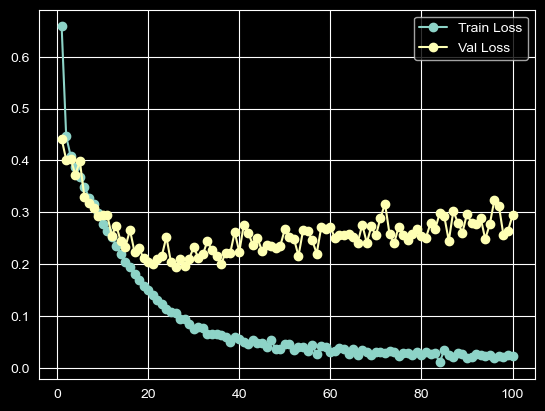

In [44]:
custom_model = CustomArchitecture(input_size=512, num_classes=10)
custom_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_model.parameters(), lr=LEARNING_RATE)
train_model(custom_model, train_new_loader, val_new_loader, optimizer, criterion, verbose=False)

Printing statistics...
Test Loss: 0.2922
Overall Accuracy: 0.9486
F1 Score (weighted): 0.9486
Accuracy for class 0: 0.9321
Accuracy for class 1: 0.9855
Accuracy for class 2: 0.9750
Accuracy for class 3: 0.8975
Accuracy for class 4: 0.9280
Accuracy for class 5: 0.9199
Accuracy for class 6: 0.9560
Accuracy for class 7: 0.9501
Accuracy for class 8: 0.9729
Accuracy for class 9: 0.9639


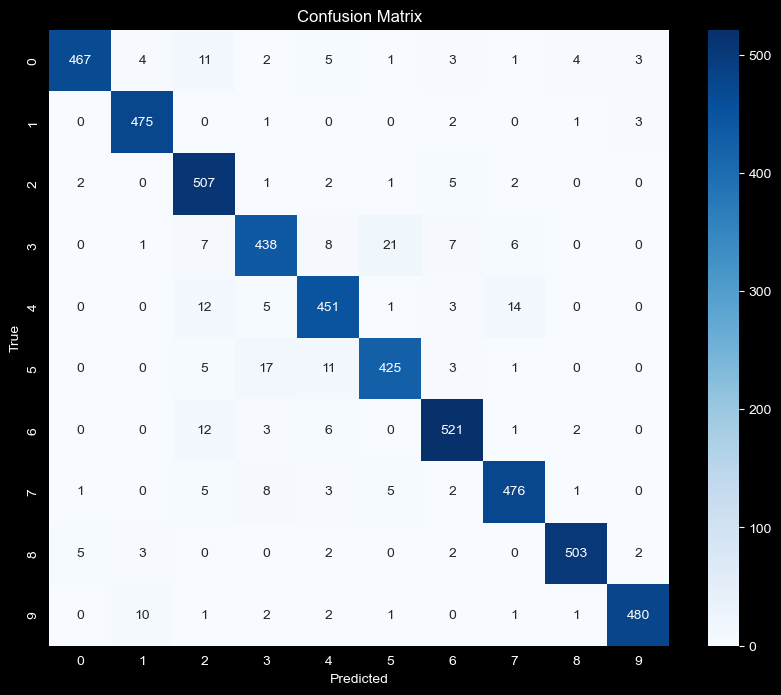

(0.2922476565718651,
 0.9486,
 0.948620034228879,
 array([[467,   4,  11,   2,   5,   1,   3,   1,   4,   3],
        [  0, 475,   0,   1,   0,   0,   2,   0,   1,   3],
        [  2,   0, 507,   1,   2,   1,   5,   2,   0,   0],
        [  0,   1,   7, 438,   8,  21,   7,   6,   0,   0],
        [  0,   0,  12,   5, 451,   1,   3,  14,   0,   0],
        [  0,   0,   5,  17,  11, 425,   3,   1,   0,   0],
        [  0,   0,  12,   3,   6,   0, 521,   1,   2,   0],
        [  1,   0,   5,   8,   3,   5,   2, 476,   1,   0],
        [  5,   3,   0,   0,   2,   0,   2,   0, 503,   2],
        [  0,  10,   1,   2,   2,   1,   0,   1,   1, 480]], dtype=int64),
 array([0.93213573, 0.98547718, 0.975     , 0.89754098, 0.92798354,
        0.91991342, 0.9559633 , 0.9500998 , 0.9729207 , 0.96385542]))

In [45]:
evaluate_model(custom_model, test_new_loader, range(10))